In [ ]:
#unsupervised gaussian mixture
#https://www.physionet.org/content/noneeg/1.0.0/
%%capture
# connects the google drive
from google.colab import drive
drive.mount(r"/content/drive")
#enables better vizualization for dataframes


Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
%%capture
%pip install wfdb
%pip install --upgrade scipy
%pip install neurokit2
# %pip install mpl_toolkits
# %pip install mpld3
# %pip install ipympl

In [ ]:
%reset -f
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import os
import wfdb
import scipy
import numpy as np
import pandas as pd
import neurokit2 as nk
import statistics
from scipy.signal import resample
import math
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_rows', None)
# from scipy.stats import skew, kurtosis


df = pd.DataFrame() #Dataframe for signals in total
Ts = 10 #segmentation time in seconds
df_signal = pd.DataFrame() #DataFrame for entire signals
df_events = pd.DataFrame() #DataFrame for each activity (relax, cognitive stress, etc.)
df_features = pd.DataFrame() #Dataframe for each feature (mean, std)
total_index = pd.Index([]) #Index values to gather them up


##Filtering parameters for all of the signals
#accelerometer: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6539652/
#Temperature:
#eda: https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/eda/eda_clean.html
#SpO2: https://sci-hub.st/https://pubmed.ncbi.nlm.nih.gov/23126791/
#HR: https://sci-hub.st/10.1109/ICCICT.2012.6398145
filt = pd.DataFrame({"lowcut":["None" , "None", "None", "None", "None", "None", "0.5"],
                     "highcut":["10", "10", "10", "10", "3", "15", "100"],
                     "order":[4, 4, 4, 4, 4, 4, 4]})

##feature extraction for machine learning
#accelerometer: https://arxiv.org/pdf/1510.04221.pdf ("PRE-PROCESSING")
#EDA: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9215837/ (introduction)
#temperature: https://www.mdpi.com/1424-8220/17/10/2435 (table 1.) SKT = skin temperature

eda_features = ["Mean", "std", "first abs diff", "norm first abs diff"]
accelerometer_feautures = ["Mean", "std", "variance"]
Temperature_features = ["Mean", "std", "diff"]

features_name = [" Mean", " Std", " Var"]

# specify the directory you want to use
directory = 'drive/MyDrive/new stress test/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0'

# get a list of all files in the directory
files = os.listdir(directory)

# filter out the files you don't want
files = [f for f in files if f not in ["ANNOTATORS", "RECORDS", "SHA256SUMS.gdoc","subjectinfo.gsheet"]]

# sort the list of files alphabetically
files.sort()

# now you can loop over the files and load them one by one
for filename in files:


  filepath = os.path.join(directory, filename)
  # load the file (this depends on the file type and the library you're using)
  # get the file extension
  extension = os.path.splitext(filename)[1]
  # check if the file has one of the extensions we're interested in
  if extension in ['.dat', '.atr']:
    # remove the extension from the filename
    record_name = os.path.splitext(filename)[0]
    # create the full path to the record (without extension)
    record_path = os.path.join(directory, record_name)
    # load the file using wfdb (this depends on the file type)

    if extension == '.atr':
      # sampling frequency
      fs = 8

      # if the dataframe is not empty (which is not the first run):
      if filename != files[0]:

        #Normalization signal for each individual data
        df_events = (df_events - df_events.min()) / (df_events.max() - df_events.min())

        #T-distributed Stochastic Neighbor Embedding
        X_tsne = TSNE(n_components=2, random_state=12).fit_transform(df_events)
        # X_tsne = PCA(n_components = 2, random_state=25).fit_transform(df_events)

        #Gaussian function
        gmm = GaussianMixture(n_components=4, random_state=12).fit(X_tsne)

        #Predicting the each cluster
        df_events["Predictions"] =  gmm.predict(X_tsne)

        #Cluster Mean of the all features
        Mean = df_events.groupby("Predictions").mean()

        #Defining PhysicalStress & Dropping the cluster value
        df_events['Predictions'].replace(Mean["hr Mean"].idxmax(), "PhysicalStress", inplace=True)
        Mean.drop(index = Mean["hr Mean"].idxmax(), inplace = True)

        #Replacing the Relax
        df_events['Predictions'].replace(Mean["temp Mean"].idxmin(), "Relax", inplace=True)
        Mean.drop(index = Mean["temp Mean"].idxmin(), inplace = True)

        #Replacing the CognitiveStress
        df_events['Predictions'].replace(Mean["hr Mean"].idxmax(), "CognitiveStress", inplace=True)
        Mean.drop(index = Mean["hr Mean"].idxmax(), inplace = True)


        df_events['Predictions'].replace(Mean.index[0], "EmotionalStress", inplace=True)
        Mean = pd.DataFrame()


      #Adding all of the events to the file
      df_signal = pd.concat([df_signal, df_events])
      total_index = total_index.append(df_features.index)

      #Reseting the events dataframe
      df_events = pd.DataFrame()

      #load event time and delete the 4th index (most probably added by a mistake)
      event_times = wfdb.rdann(record_path, 'atr').sample

      #Downsampling from 8 Hz to 1 Hz
      event_times = np.fix(event_times / fs)

      #loading the event names
      events = wfdb.rdann(record_path, 'atr').aux_note


    elif extension == '.dat':
      signals = wfdb.rdrecord(record_path).p_signal
      sig_names = wfdb.rdrecord(record_path).sig_name

      #Preprocessing the each signal
      acc = []
      for i_sig, sig_name in enumerate(sig_names):
        #Taking each signal one by one
        signal = signals[:,i_sig]


        if sig_name in ["ax", "ay"]:
          acc = sum(acc,signal**2)
          continue
        elif sig_name in ["az"]:
          signal = np.sqrt(acc + signal**2) / 3
          sig_name = "Acc"


        #EDA (fs = 8) and SpO2 (fs = 1) sampling frequency were matched to 1.
        #Also "add" is for the filt dataframe in which makes it match with the correct one


        if 'EDA' in sig_names:
          fs = 8
          add = 0
          minus = 11

          #filtering with butterworth filter
          signal = nk.signal_filter(signal, highcut= literal_eval(filt["highcut"][i_sig + add]),
                                    lowcut= literal_eval(filt["lowcut"][i_sig + add]),
                                    method="butterworth", order=filt["order"][i_sig + add])

        else:
          fs = 1
          minus = 7



        # Downsample the signal if it is necessary from 8 to 1
        signal = resample(signal, len(signal) // fs)

        #Adding endpoint for the event times divided to sampling frequency to match it to 8
        total_event_time = np.append(event_times, int(len(signals) / fs))

        #standardize the signal by dividing the signal into their variance
        signal = signal / np.var(signal)

        #Each event evaluation
        df_features = pd.DataFrame()
        for i_event, _ in enumerate(total_event_time[0:-1]):

          #if statement was added to ignore the breaks other than the first one
          if i_event in [2, 3, 5, 7]:
            continue

          event_signal = signal[int(total_event_time[i_event]): int(total_event_time[i_event + 1])]




          #Taking 30 seconds of segments (Less than 30 seconds are not allowed especially the end section)
          for index in range(0, len(event_signal) - len(event_signal) % Ts - Ts, Ts):

            part_signal =  event_signal[index : index + Ts]
            features = [np.mean(part_signal)]
            features_name = [" Mean"]



            # Combining the all of the fatures into one dataframe as segmentation
            df_features = pd.concat( [ df_features, pd.DataFrame([features],
                                          columns = [sig_name + feature_name for feature_name in features_name],
                                          index = [events[i_event]]) ], axis = 0 )

        df_events = pd.concat([df_events, df_features.reset_index(drop = True)], axis = 1, join='outer')


df_signal["Labels"] = total_index
df_signal

,Acc Mean,temp Mean,EDA Mean,SpO2 Mean,hr Mean,Predictions,Labels
0,0.805790,0.001956,0.018058,6.749876e-01,0.682209,Relax,Relax
1,0.726302,0.000000,0.014217,7.499905e-01,0.434331,Relax,Relax
2,0.323518,0.034893,0.029845,5.249914e-01,0.292383,Relax,Relax
3,0.338350,0.083138,0.044989,3.999962e-01,0.269077,Relax,Relax
4,0.340083,0.123280,0.058606,3.999962e-01,0.233059,Relax,Relax
5,0.344724,0.152998,0.070111,4.999924e-01,0.072036,Relax,Relax
6,0.353374,0.182745,0.078391,5.499905e-01,0.125004,Relax,Relax
7,0.129354,0.210975,0.081076,5.749895e-01,0.199159,Relax,Relax
8,0.016651,0.242789,0.079381,6.499866e-01,0.294501,Relax,Relax
9,0.012200,0.269158,0.076649,4.499943e-01,0.233059,Relax,Relax


             CognitiveStress  EmotionalStress  PhysicalStress     Relax
Sensitivity         0.880805         0.880342        0.889643  0.994536
Specificity         0.950000         0.979260        0.971007  0.976768
Precision           0.860817         0.943511        0.905009  0.923858
Accuracy: 0.9078841512469831


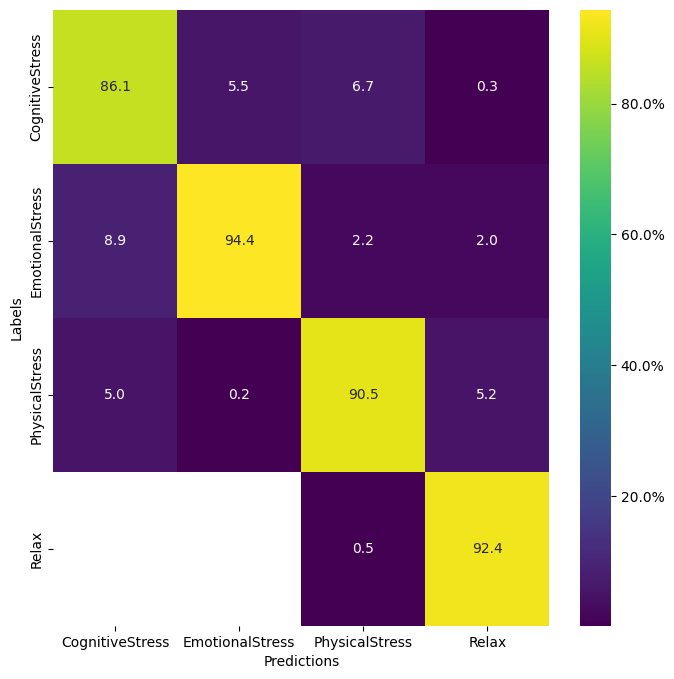

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



y_test = df_signal["Labels"]
predicted = df_signal["Predictions"]

Stress = ["CognitiveStress", "EmotionalStress", "PhysicalStress", "Relax"]

# ground truth labels (y_test) and predicted labels
conf_matrix = confusion_matrix(y_test, predicted)
# Extract individual components
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (conf_matrix.sum(axis=0) + conf_matrix.sum(axis=1) - TP)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP

Sensitivity = TP / (TP + FN)

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

SSP = pd.DataFrame([Sensitivity, Specificity, Precision], columns= Stress, index= ["Sensitivity", "Specificity", "Precision"])

print(SSP)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted)
print('Accuracy:', accuracy)

# Calculate the percentage of occurrences for each combination
df_2dhist = pd.DataFrame({
    x_label: grp['Labels'].value_counts(normalize=True) * 100
    for x_label, grp in df_signal.groupby('Predictions')
})

# Create the heatmap
plt.subplots(figsize=(8, 8))
sns.heatmap(df_2dhist, cmap='viridis', annot=True, fmt='.1f', cbar_kws={'format': '%.1f%%'})
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.show()


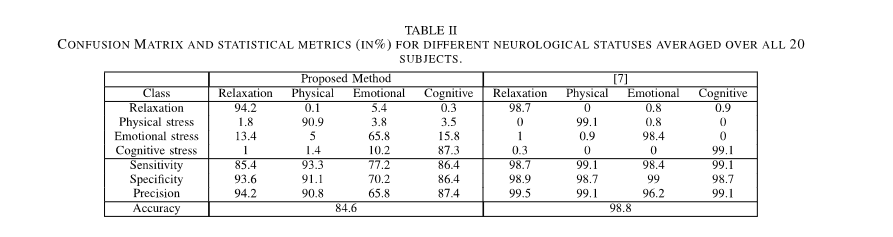

<ipython-input-5-843f0ad644ca>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_signal, x='temp Mean', y='Labels', inner='box', palette='Dark2')


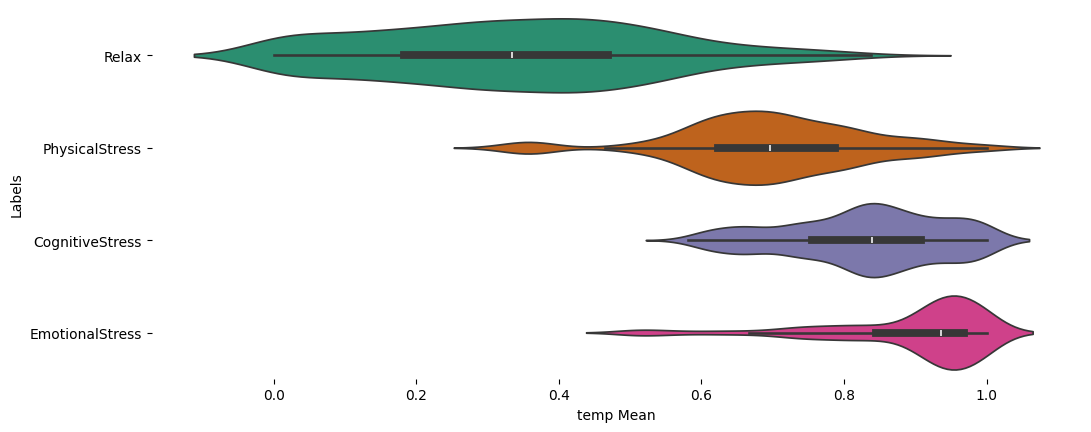

In [ ]:
# @title Temperature levels


figsize = (12, 1.2 * len(df_signal['Labels'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_signal, x='temp Mean', y='Labels', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
%reset -f
import matplotlib.pyplot as plt

from ast import literal_eval
import os
import wfdb
import scipy
import numpy as np
import pandas as pd
import neurokit2 as nk
import statistics
from scipy.signal import resample
import math


# from scipy.stats import skew, kurtosis
o = 35 #45 80

df = pd.DataFrame() #Dataframe for signals in total
Ts = 10 #segmentation time in seconds
df_signal = pd.DataFrame() #DataFrame for entire signals
df_events = pd.DataFrame() #DataFrame for each activity (relax, cognitive stress, etc.)
df_features = pd.DataFrame() #Dataframe for each feature (mean, std)
total_index = pd.Index([]) #Index values to gather them up


##Filtering parameters for all of the signals
#accelerometer: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6539652/
#Temperature:
#eda: https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/eda/eda_clean.html
#SpO2: https://sci-hub.st/https://pubmed.ncbi.nlm.nih.gov/23126791/
#HR: https://sci-hub.st/10.1109/ICCICT.2012.6398145
filt = pd.DataFrame({"lowcut":["None" , "None", "None", "None", "None", "None", "0.5"],
                     "highcut":["10", "10", "10", "10", "3", "15", "100"],
                     "order":[4, 4, 4, 4, 4, 4, 4]})

##feature extraction for machine learning
#accelerometer: https://arxiv.org/pdf/1510.04221.pdf ("PRE-PROCESSING")
#EDA: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9215837/ (introduction)
#temperature: https://www.mdpi.com/1424-8220/17/10/2435 (table 1.) SKT = skin temperature

eda_features = ["Mean", "std", "first abs diff", "norm first abs diff"]
accelerometer_feautures = ["Mean", "std", "variance"]
Temperature_features = ["Mean", "std", "diff"]

features_name = [" Mean", " Std", " Var"]

# specify the directory you want to use
directory = 'drive/MyDrive/new stress test/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0'

# get a list of all files in the directory
files = os.listdir(directory)

# filter out the files you don't want
files = [f for f in files if f not in ["ANNOTATORS", "RECORDS", "SHA256SUMS.gdoc","subjectinfo.gsheet"]]

# sort the list of files alphabetically
files.sort()
files = files[o:o+5]
# now you can loop over the files and load them one by one
for person_i, filename in enumerate(files):
  print(filename)
  # if person_i % 2 == 0:
  #   df_events = pd.DataFrame()
  filepath = os.path.join(directory, filename)
  # load the file (this depends on the file type and the library you're using)
  # get the file extension
  extension = os.path.splitext(filename)[1]
  # check if the file has one of the extensions we're interested in
  if extension in ['.dat', '.atr']:
    # remove the extension from the filename
    record_name = os.path.splitext(filename)[0]
    # create the full path to the record (without extension)
    record_path = os.path.join(directory, record_name)
    # load the file using wfdb (this depends on the file type)

    if extension == '.atr':
      # sampling frequency
      fs = 8
      #Adding all of the events to the file
      df_signal = pd.concat([df_signal, df_events])

      total_index = total_index.append(df_features.index)

      #Reseting the events dataframe
      df_events = pd.DataFrame()

      #load event time and delete the 4th index (most probably added by a mistake)
      event_times = wfdb.rdann(record_path, 'atr').sample

      #Downsampling from 8 Hz to 1 Hz
      event_times = np.fix(event_times / fs)

      #loading the event names
      events = wfdb.rdann(record_path, 'atr').aux_note


    elif extension == '.dat':
      signals = wfdb.rdrecord(record_path).p_signal
      sig_names = wfdb.rdrecord(record_path).sig_name

      #Preprocessing the each signal
      acc = []
      for i_sig, sig_name in enumerate(sig_names):
        #Taking each signal one by one
        signal = signals[:,i_sig]

        # if sig_name in ["SpO2"]:
        #   print("SpO2")
        #   continue
        # if sig_name in ["az", "ax", "ay"]:
        #   continue
        if sig_name in ["ax", "ay"]:
          acc = sum(acc,signal**2)
          continue
        elif sig_name in ["az"]:
          signal = np.sqrt(acc + signal**2) / 3
          sig_name = "Acc"


        #EDA (fs = 8) and SpO2 (fs = 1) sampling frequency were matched to 1.
        #Also "add" is for the filt dataframe in which makes it match with the correct one


        if 'EDA' in sig_names:
          fs = 8
          add = 0
          minus = 11

          #filtering with butterworth filter
          signal = nk.signal_filter(signal, highcut= literal_eval(filt["highcut"][i_sig + add]),
                                    lowcut= literal_eval(filt["lowcut"][i_sig + add]),
                                    method="butterworth", order=filt["order"][i_sig + add])

        else:
          fs = 1
          minus = 7

        # Downsample the signal if it is necessary from 8 to 1
        signal = resample(signal, len(signal) // fs)

        #Adding endpoint for the event times divided to sampling frequency to match it to 8
        total_event_time = np.append(event_times, int(len(signals) / fs))

        #standardize the signal by dividing the signal into their variance
        signal = signal / np.var(signal)

        #Each event evaluation
        df_features = pd.DataFrame()
        for i_event, _ in enumerate(total_event_time[0:-1]):

          #if statement was added to ignore the breaks other than the first one
          if i_event in [2, 3, 5, 7]:
            continue

          event_signal = signal[int(total_event_time[i_event]): int(total_event_time[i_event + 1])]




          #Taking 30 seconds of segments (Less than 30 seconds are not allowed especially the end section)
          for index in range(0, len(event_signal) - len(event_signal) % Ts - Ts, Ts):

            part_signal =  event_signal[index : index + Ts]
            features = [np.mean(part_signal)]
            features_name = [" Mean"]



            # Combining the all of the fatures into one dataframe as segmentation
            df_features = pd.concat( [ df_features, pd.DataFrame([features],
                                          columns = [sig_name + feature_name for feature_name in features_name],
                                          index = [events[i_event]]) ], axis = 0 )

        df_events = pd.concat([df_events, df_features.reset_index(drop = True)], axis = 1, join='outer')


df_signal.index = total_index

Subject17_AccTempEDA.atr
Subject17_AccTempEDA.dat
Subject17_AccTempEDA.hea
Subject17_SpO2HR.dat
Subject17_SpO2HR.hea


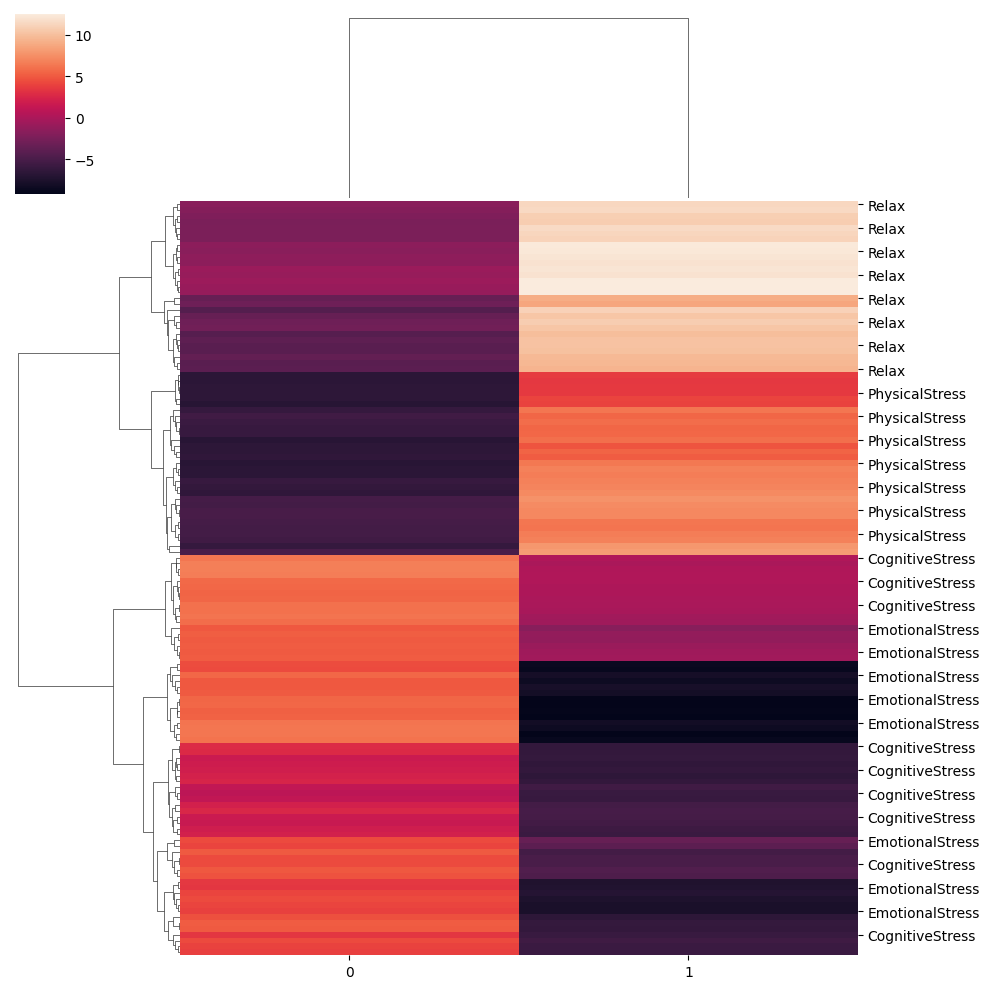

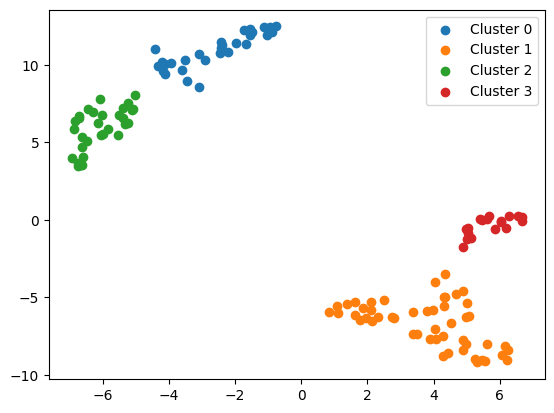

{0: 'Relax', 1: 'EmotionalStress', 2: 'PhysicalStress', 3: 'CognitiveStress'}
mean Cluster
CognitiveStress    1.125312
EmotionalStress    1.097259
PhysicalStress     0.844064
Relax              0.120161
Name: new, dtype: float64
                         Cluster
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax                      Relax
Relax       

In [ ]:
#cluster signal for visualization
clus_sig = "new"

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.offline as pyo
# from mpl_toolkits.mplot3d import Axes3D


#Setting up the dataframe
df = df_events.copy()
# df["SpO2 Mean"] = -df["SpO2 Mean"]
df.index = df_features.index


#Normalization
df = (df - df.min()) / (df.max() - df.min())

#Scaling the data in order to match the it better
scaler = StandardScaler()
X = scaler.fit_transform(df)


# X = df

# X = PCA(n_components = 4, random_state=25).fit_transform(X)

#T-distributed Stochastic Neighbor Embedding
X_tsne = TSNE(n_components=2, random_state=25).fit_transform(X)


#Gaussian function
gmm = GaussianMixture(n_components=4, random_state=25).fit(X_tsne)


#Predicting the each cluster
df["Cluster"] =  gmm.predict(X_tsne)

# get the most frequent index value for each cluster value
most_frequent = df.groupby('Cluster').apply(lambda x: x.index.value_counts().index[0])

# get the ratio (%) of each cluster that matches with the others.
ratio_frequent = df.groupby('Cluster').apply(lambda x: (x.index.value_counts().iloc[0] / len(x)) * 100)

# Combining the ratio and frequently used index values into one dataframe
Cluster_frequent = pd.concat([most_frequent, ratio_frequent], axis = 1)

# Finding the duplicated value that has the least match
Duplicated = Cluster_frequent[Cluster_frequent[0].duplicated(keep = False)]

#cluster mapping
# Extract the 1-dimensional index array

sns.clustermap(pd.DataFrame(X_tsne, index = df.index))
plt.show()

# create a pd.Series for each Stress type in a sorted way
index_series = pd.Series(["CognitiveStress", "Relax", "EmotionalStress", "PhysicalStress"])

# mapping based on the labels all ready existed
mapping = dict(zip(most_frequent.index, most_frequent.values))


for i in range(4):
  plt.scatter(X_tsne[gmm.predict(X_tsne) == i, 0], X_tsne[gmm.predict(X_tsne) == i, 1], label = f"Cluster {i}")
plt.legend()
# Show the plot
plt.show()




# replace the values in the "cluster" column with the corresponding index values
df['Cluster'] = df['Cluster'].replace(mapping)
line = ["Relax", "Physical", "Emotional", "Cognitive"]
print(mapping)




df["new"] = (df["hr Mean"] + df["EDA Mean"])

# sns.violinplot(x="Cluster", y=clus_sig, data=df)

print("mean",df.groupby("Cluster")[clus_sig].mean())

#emotional stress: 1) eda dusecek 2) spo2 artacak 3) hr artacak

print(df[["Cluster"]].to_string())

#hr = physicalstress has the highest mean
#Temp = relax has the lowest  mean
#hr = highest hr shows the cognitive stress when it is compared to emotionalstress